In [61]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random

# Time Series Analysis of Energy Data

Prompt: "Make a dataset containing power output (in megawatts) from a solar farm recorded hourly over a month. Then write a Python script to analyze the time series data. Your script should identify the peak production hours and any anomalous dips in power generation. Also, include a brief explanation of how weather or other external factors might affect these readings."

Skills Tested: Data manipulation, time series analysis, basic understanding of renewable energy systems.

## Create sample data

In [75]:
sample_df = pd.DataFrame(pd.date_range(start='1/1/2023', end='1/31/2023 23:00', freq='H'), columns=['date'])
sample_df.set_index('date', inplace=True)

# Constants
DAYS = 31
HOURS_IN_DAY = 24
MEAN_SUNLIGHT_HOUR = 12  # Assuming peak sunlight at noon
STD_DEV = 3  # Standard deviation in hours, determines how "spread out" the sunlight hours are
SAMPLE_PEAK_POWER = 10 # in MW

power_output = []
for day in range(DAYS):
    # Create a daily profile centered around noon with 3 hours of spread:
    hours = np.arange(HOURS_IN_DAY)
    daily_power_output = norm.pdf(x=hours, loc=MEAN_SUNLIGHT_HOUR, scale=STD_DEV)
    daily_power_output = np.clip(daily_power_output, a_min=0, a_max=None) # Clip values less than 0
    # Normalize by the maximum, multiply by the sample peak power, then randomly multiply by a value between 0.8-1.1 for daily variety
    daily_power_output = daily_power_output / daily_power_output.max() * SAMPLE_PEAK_POWER * random.uniform(0.8,1.1)
    power_output.extend(daily_power_output)
    
sample_df["power_output"] = power_output

In [72]:
sample_df

,power_output
date,
2023-01-01 00:00:00,0.003539
2023-01-01 01:00:00,0.012702
2023-01-01 02:00:00,0.040788
2023-01-01 03:00:00,0.117208
2023-01-01 04:00:00,0.301387
...,...
2023-01-31 19:00:00,0.653567
2023-01-31 20:00:00,0.284039
2023-01-31 21:00:00,0.110462


<Axes: title={'center': 'Day 1 of Sample Power Data'}, xlabel='date'>

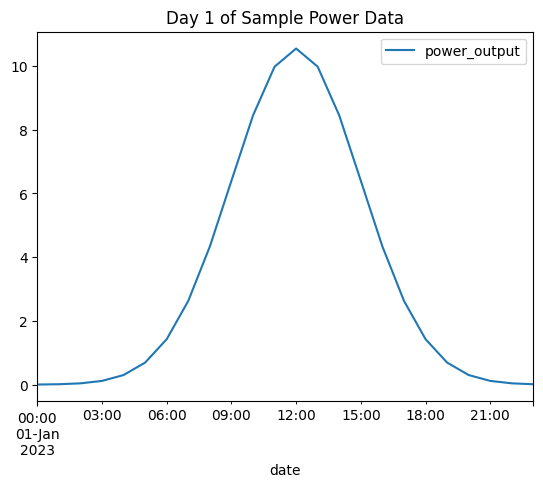

In [73]:
sample_df[0:24].plot(title="Day 1 of Sample Power Data")

<Axes: xlabel='date'>

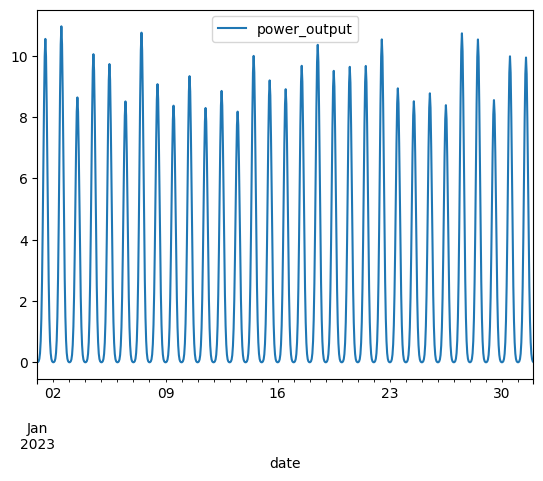

In [74]:
sample_df.plot()

## Identify the peak production hours and any anomalous dips in power generation

In [101]:
# Identify top 10 power output values
top_10_power = sample_df.sort_values(by="power_output", ascending=False)[0:10]
top_10_power

,power_output
date,
2023-01-05 12:00:00,10.895936
2023-01-24 12:00:00,10.750121
2023-01-20 12:00:00,10.540562
2023-01-23 12:00:00,10.538390
2023-01-16 12:00:00,10.477409
2023-01-05 11:00:00,10.307114
2023-01-05 13:00:00,10.307114
2023-01-29 12:00:00,10.307012
2023-01-08 12:00:00,10.305145


In [102]:
print(f"Top 10 power outputs from hour {top_10_power.index.hour.min()} to {top_10_power.index.hour.max()}")

Top 10 power outputs from hour 11 to 13


In [139]:
# Identify any anomalous dips in power generation
# First, to find anomalous dips, lets focus on peak hours -- hours 11 to 13 -- and find the 95th percentile
sample_df_peak_hours = sample_df[(sample_df.index.hour>=11)&(sample_df.index.hour<=13)]
min_threshold = sample_df_peak_hours["power_output"].quantile(0.05)

for hour, value in sample_df_peak_hours.iterrows():
    if value["power_output"] < min_threshold:
        print(f"Anomalous dip occurs at {hour} with value {round(value['power_output'],3)}")

Anomalous dip occurs at 2023-01-02 11:00:00 with value 7.589
Anomalous dip occurs at 2023-01-02 13:00:00 with value 7.589
Anomalous dip occurs at 2023-01-27 11:00:00 with value 7.595
Anomalous dip occurs at 2023-01-27 13:00:00 with value 7.595


## Include a brief explanation of how weather or other external factors might affect these readings